In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import sys
import tempfile
import itertools

import tensorflow as tf

from categorical_embedding_tf_train import loaddata, streaming_mape, input_fn
from categorical_embedding_tf_model import build_estimator

Loading the data:

In [2]:
df_train, df_test = loaddata()

df_validation = df_train[df_train['retailweek'] > '2017-02-28']
df_train = df_train[df_train['retailweek'] < '2017-02-28']

model_dir = "/home/jc/workspace/adidas_take_home/model_dir_test2/"
model_dir = tempfile.mkdtemp() if not model_dir else model_dir

In [3]:
# hidden_layer = [60, 60]
m = build_estimator(model_dir)

INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 100, '_num_ps_replicas': 0, '_keep_checkpoint_max': 3, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4331afa590>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [4]:
validation_metrics = {
    "mae":
        tf.contrib.learn.MetricSpec(
            metric_fn=tf.contrib.metrics.streaming_mean_absolute_error,
        ),
    "mape":
        tf.contrib.learn.MetricSpec(
            metric_fn=streaming_mape,
        )
}

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn=lambda: input_fn(df_validation),
    eval_steps=1,  # Try adding this
    metrics=validation_metrics,
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50
)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [9]:
m.fit(
    input_fn=lambda: input_fn(df_train),
    steps=10000,
    monitors=[validation_monitor],
)

results = m.evaluate(input_fn=lambda: input_fn(df_test), steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histog

In [10]:
LABEL_COLUMN = 'saleslog'

# Print out predictions
y = m.predict(input_fn=lambda: input_fn(df_test))
# .predict() returns an iterator; convert to a list and print predictions
# islice(y,10) only the first 10 prediction results
predictions = list(itertools.islice(y, df_test.shape[0]))
real = list(df_test[LABEL_COLUMN])

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instru

In [11]:
import numpy as np
def mape(y,yhat):
    return np.mean( np.abs((y-yhat) / y) )

def mape_xg(yhat, y):
    y = np.array(y)
    yhat = np.array(yhat)
    return "mape", mape(y,yhat)

mape_xg(real, predictions)

('mape', 0.29784673)

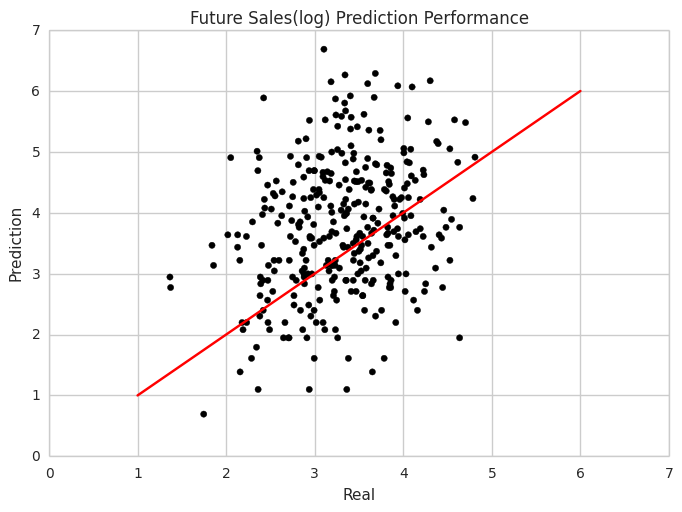

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns
sns.set_style('whitegrid')

df_agg_result = pd.DataFrame({'pred': real,
                              'real': predictions})

result_sample = df_agg_result.sample(frac=0.1)

fig, ax = plt.subplots()
ax.scatter(result_sample['real'], result_sample['pred'], c='black')
plt.plot([1, 6], [1, 6], 'k-', color = 'r')
plt.title('Future Sales(log) Prediction Performance')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.show()

After 9700 rounds of training, MAPE reaches 0.28610489